In [74]:
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta

In [75]:
# We have data about all employees who joined from 2011/01/24 to 2015/12/13.
employee_retention = pd.read_csv('employee_retention_data.csv')

In [76]:
employee_retention.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [77]:
employee_retention.describe(include = 'all')

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
count,24702.000000,24702.000000,24702,24702.000000,24702.000000,24702,13510
unique,NaN,NaN,6,NaN,NaN,995,664
top,NaN,NaN,customer_service,NaN,NaN,2012-01-03,2015-05-08
freq,NaN,NaN,9180,NaN,NaN,105,111
mean,501604.403530,3.426969,NaN,14.127803,138183.345478,NaN,NaN
std,288909.026101,2.700011,NaN,8.089520,76058.184573,NaN,NaN
min,36.000000,1.000000,NaN,1.000000,17000.000000,NaN,NaN
25%,250133.750000,1.000000,NaN,7.000000,79000.000000,NaN,NaN
50%,500793.000000,2.000000,NaN,14.000000,123000.000000,NaN,NaN
75%,753137.250000,5.000000,NaN,21.000000,187000.000000,NaN,NaN


The max seniority is 99, which is absurd.
Except for quit date, all the other rows have 24702 entries. Around half of the employees didn't leave. 

In [78]:
#fill in the na in quit_date column with the date after the end of the period and remove the 'seniority' outliers
employee_retention['quit_date'].fillna(value = '2015-12-14', inplace = True)
employee_retention = employee_retention[employee_retention['seniority'] < 40]

# create a table with day, employee_headcount, company_id

In [6]:
period_start = datetime(2011,1,24)
period_end = datetime(2015,12,13)
total_days = (period_end - period_start).days + 1
days_list = [datetime.strftime(period_start + timedelta(days=x),'%Y-%m-%d') for x in range(0, total_days)]

In [7]:
#create company map
company_id = employee_retention.company_id.unique()
num_company = len(company_id)
print(company_id)
#company id are continuous number, we can use company_id-1 as the index for numpy array. 

[ 7  4  2  9  1  6 10  5  3  8 11 12]


In [8]:
def get_time_index(date_str, period_start):
    return (datetime.strptime(date_str,'%Y-%m-%d') - period_start).days

In [9]:
#loop over the array, add 1 to the range from beginning date to the end date
date_company = np.zeros((total_days, 12), dtype=np.int)
period_start = datetime(2011,1,24)
for i in range(employee_retention.shape[0]):
    start_date = employee_retention.loc[i, 'join_date']
    start_ind = get_time_index(start_date, period_start)
    end_date = employee_retention.loc[i, 'quit_date']
    end_ind = get_time_index(end_date, period_start)
    company_ind = employee_retention.loc[i, 'company_id'] - 1
    date_company[start_ind:end_ind+1, company_ind] = date_company[start_ind:end_ind+1, company_ind] + 1

In [10]:
date_company

array([[  25,   17,    9, ...,    0,    0,    0],
       [  27,   19,   10, ...,    0,    0,    0],
       [  29,   19,   12, ...,    0,    0,    0],
       ..., 
       [3865, 2016, 1218, ...,  385,    4,   12],
       [3865, 2016, 1218, ...,  385,    4,   12],
       [3865, 2016, 1218, ...,  385,    4,   12]])

In [11]:
# generate head_count table by unpivoting the date_company matrix
date_company_entries = date_company.ravel('F')
company_id_repeats= np.asarray(np.arange(1,13)).repeat(total_days)
date_repeats = np.tile(np.asarray(days_list),num_company)

data = {'date': date_repeats, 'company_id': company_id_repeats, 'number_employees': date_company_entries}
head_count_table = pd.DataFrame(data, columns = ['date', 'company_id', 'number_employees'])

In [12]:
head_count_table.head(5)

,date,company_id,number_employees
0,2011-01-24,1,25
1,2011-01-25,1,27
2,2011-01-26,1,29
3,2011-01-27,1,29
4,2011-01-28,1,29


# Main factors driving employee churn - classification setting

In [79]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [80]:
#generate classifiction labels 
employee_retention['left'] = employee_retention['quit_date'].apply(lambda x: 1 if x != '2015-12-14' else 0)

In [81]:
num_employee = employee_retention.shape[0]
num_left_employee = sum(employee_retention['left'])
print "{} employees left, {} employees stayed".format(num_left_employee, num_employee - num_left_employee)

13508 employees left, 11192 employees stayed


In [82]:
feature = employee_retention.drop(['employee_id', 'join_date', 'quit_date','left'], axis = 1)
feature = pd.get_dummies(feature, drop_first=True)
label = employee_retention['left']

In [83]:
feature.head(2)

,company_id,seniority,salary,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,7,28,89000.0,0,0,0,0,0
1,7,20,183000.0,0,0,0,1,0


In [84]:
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.3, random_state=0)

In [85]:
# logistic regression model
from sklearn.linear_model import LogisticRegression
logistic_classifier = LogisticRegression()
logistic_classifier.fit(x_train, y_train)
lr_preds = logistic_classifier.predict(x_test)

In [86]:
print "The accuracy of logistic regression classifier is {}.".format(accuracy_score(y_test, lr_preds))

The accuracy of logistic regression classifier is 0.547638326586.


In [87]:
# Logistic regression in scikit learn does not give feature importance, so here I use the random forest classifier. 
# # tuning RF parameters. https://www.kaggle.com/hadend/tuning-random-forest-parameters
# # https://www.kaggle.com/general/4092
rf_clf = RandomForestClassifier(min_samples_leaf=25, n_estimators=20)
rf_clf.fit(x_train, y_train)
rf_preds = rf_clf.predict(x_test)
print "The accuracy of random forest classifier is {}.".format(accuracy_score(y_test, rf_preds))
# print(classification_report(y_test, rf_preds))

The accuracy of random forest classifier is 0.553171390013.


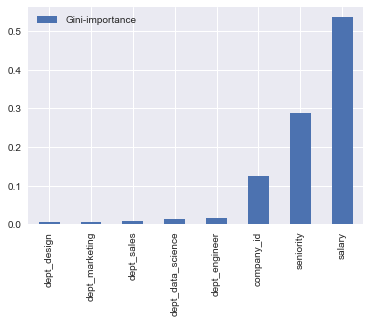

In [88]:
# plot feature importance
feats = {} 
for feature, importance in zip(feature.columns, rf_clf.feature_importances_):
    feats[feature] = importance 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)

# Moving to a regression setting

Consider some feature engineering.The impression is that the employers have larger tendency to leave their job after being there for a while. So the employment length should be a factor in predicting whether an employer will leave. But the problem is that if we use employment_length = quit_date-join_date to predict whether an employer will leave, there will be data leakage? 

Re-read the problem, the task is to predict when employees is going to quit. So I think the problem should be re-formulated as a regression problem, in which we try to predict employment length. But in this case, only the data which left == 1 is usable... 

In [94]:
def length_of_stay(end_date_str, start_date_str):
    return (datetime.strptime(end_date_str,'%Y-%m-%d') - datetime.strptime(start_date_str,'%Y-%m-%d')).days

employee_retention['length_of_stay'] = employee_retention[['quit_date','join_date']].\
                                        apply(lambda x: length_of_stay(*x), axis = 1)

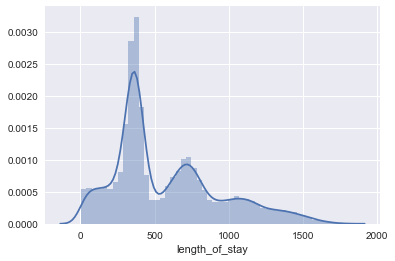

In [95]:
sns.distplot(employee_retention['length_of_stay'])

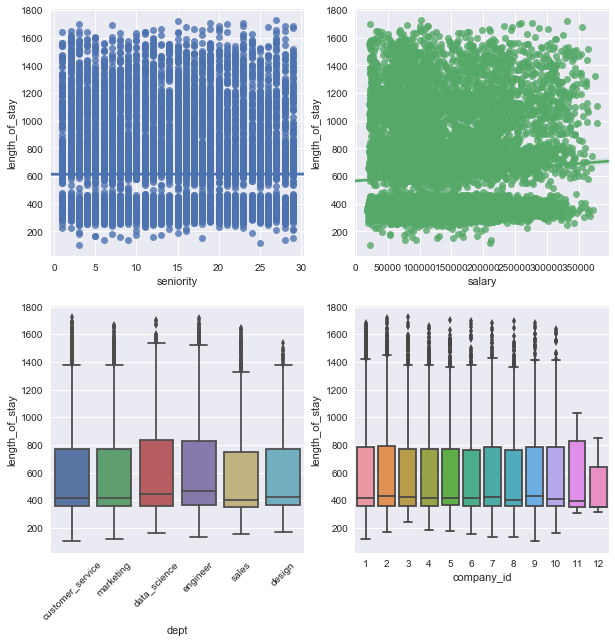

In [61]:
#visualize the relationship between features and employment length
employee_retention_part = employee_retention[employee_retention['left'] == 1]
sns.set(font_scale=1) 
fig, axs = plt.subplots(nrows = 2, ncols=2, figsize=(10,10))
sns.regplot(x='seniority', y='length_of_stay', data=employee_retention_part, ax=axs[0][0])
sns.regplot(x='salary', y='length_of_stay', data=employee_retention_part, ax=axs[0][1])
sns.boxplot(x='dept',y='length_of_stay', data=employee_retention_part, ax=axs[1][0])
sns.boxplot(x='company_id',y='length_of_stay', data=employee_retention_part, ax=axs[1][1])
for tick in axs[1][0].get_xticklabels():
    tick.set_rotation(45)

The distribution of length_of_stay showed interesting characteristics. There are two strong peaks, one around 300 and the other around 700. So people tend to stay multiples of years. 
From the plot below, it seems people with higher salaries tend to stay longer, which also makes sense. But this is not an actionable idea, as we cannot just tell companies to raise salary to keep the employees. 

# Survival Analysis

In [89]:
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler

In [107]:
# pre-processing data: get-dummy variables, standarize the data
# standarization is not essential. But here we focus on the importance of the feature rather 
# than the actual coefficient, standarization will help the algorithm to stablize and converge
# faster. 
survival_data = employee_retention.drop(['employee_id', 'join_date', 'quit_date'],\
                                       axis = 1)
survival_data = pd.get_dummies(survival_data, drop_first=True)

scaler = StandardScaler()
survival_data[['seniority', 'salary']] = scaler.fit_transform(survival_data\
                                                              [['seniority', 'salary']])

In [98]:
survival_data.head(2)

,company_id,seniority,salary,left,length_of_stay,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,7,28,89000.0,1,585,0,0,0,0,0
1,7,20,183000.0,1,340,0,0,0,1,0


In [105]:
cph = CoxPHFitter()
cph.fit(survival_data, duration_col='length_of_stay', event_col='left')
cph.print_summary()  # access the results using cph.summary

n=24700, number of events=13508

                     coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
company_id        -0.0007     0.9993    0.0034 -0.2232 0.8234     -0.0073      0.0058     
seniority          0.0864     1.0902    0.0136  6.3466 0.0000      0.0597      0.1130  ***
salary            -0.1435     0.8663    0.0189 -7.5926 0.0000     -0.1805     -0.1064  ***
dept_data_science  0.0619     1.0639    0.0416  1.4875 0.1369     -0.0197      0.1435     
dept_design        0.0922     1.0966    0.0407  2.2686 0.0233      0.0125      0.1720    *
dept_engineer      0.0350     1.0356    0.0396  0.8824 0.3775     -0.0427      0.1127     
dept_marketing     0.1162     1.1232    0.0305  3.8072 0.0001      0.0564      0.1760  ***
dept_sales         0.1623     1.1762    0.0303  5.3539 0.0000      0.1029      0.2217  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.534


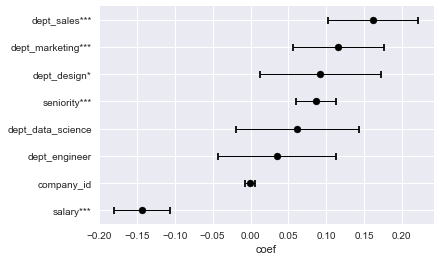

In [106]:
cph.plot()

Usually, |z| is greater than 2 means the feature is important in regression analysis. 
Conclusion: 
The more senior, the more chance to quit. 
The higher the salary, the smaller chance to quit. 
Sales and marketing people quit more frequent. 

If one more feature could be add, I would choose employment history, especially the average previous employment length for each of the employees. 